In [1]:
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
words_by_lang = dict()

for filename in glob.glob('./data/common-words/*.txt'):
    lang = os.path.splitext(os.path.basename(filename))[0]
    words = open(filename).read().strip().split('\n')
    words_by_lang[lang] = words
    
all_langs = list(words_by_lang.keys())
n_langs = len(all_langs)

from functools import reduce

all_chars = reduce(lambda a, b: a.union(set(''.join(b))), words_by_lang.values(), set())
all_chars = list(all_chars)
n_chars = len(all_chars)

In [3]:
class RNN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size, n_langs):
		super(RNN, self).__init__()
		self.hidden_size = hidden_size
        
		self.i2h = nn.Linear(n_langs + input_size + hidden_size, hidden_size)
		self.i2o = nn.Linear(n_langs + input_size + hidden_size, output_size)
		self.o2o = nn.Linear(hidden_size + output_size, output_size)
		self.dropout = nn.Dropout(0.1)
		self.softmax = nn.LogSoftmax(dim=1)


	def forward(self, lang, input, hidden):
		input_combined = torch.cat((lang, input, hidden), 1)
		hidden = self.i2h(input_combined)
		output = self.i2o(input_combined)
		output_combined = torch.cat((hidden, output), 1)
		output = self.o2o(output_combined)
		output = self.dropout(output)
		output = self.softmax(output)
		return output, hidden
	

	def initHidden(self):
		return torch.zeros(1, self.hidden_size)

In [4]:
def one_hot_lang_tensor(lang):
	tensor = torch.zeros(1, n_langs)
	tensor[0][all_langs.index(lang)] = 1
	return tensor


def one_hot_input_tensor(word):	
	tensor = torch.zeros(len(word), 1, n_chars) 

	for i, c in enumerate(word):
		tensor[i][0][all_chars.index(c)] = 1

	return tensor


def indices_target_tensor(word):
	char_indices = [all_chars.index(c) for c in word][1:] 	# indices excluding first char
	char_indices.append(n_chars) 							# and including EOS symbol
	return torch.LongTensor(char_indices)


import random


def random_training_example():
	lang = random.choice(all_langs)
	word = random.choice(words_by_lang[lang])

	lang_tensor = one_hot_lang_tensor(lang)
	input_tensor = one_hot_input_tensor(word)
	target_tensor = indices_target_tensor(word) 

	return lang_tensor, input_tensor, target_tensor


In [5]:
def train(rnn, device, criterion, opt, lang_tensor, input_tensor, target_tensor):
	lang_tensor, input_tensor, target_tensor, hidden = (
		lang_tensor.to(device),
		input_tensor.to(device),
		target_tensor.to(device),
		rnn.initHidden().to(device)
	)
	target_tensor.unsqueeze_(-1)

	opt.zero_grad()
	loss = torch.Tensor([0])

	for i in range(input_tensor.size()[0]):
		out, hidden = rnn(lang_tensor, input_tensor[i], hidden)
		loss += criterion(out, target_tensor[i])

	loss.backward()
	opt.step()

	return out, loss.item() / input_tensor.size()[0]

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'CUDA enabled: {use_cuda}')

learning_rate = 0.005
criterion = nn.NLLLoss() 
rnn = RNN(n_chars, 128, n_chars+1, n_langs)
rnn = rnn.to(device)
opt = optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 200000
check_every = 5000

current_loss = 0
all_losses = []

for i in range(1, n_iters + 1):
	out, loss = train(rnn, device, criterion, opt, *random_training_example())
	current_loss += loss
    
	if i % check_every == 0:
		print(f'{i} {i / n_iters * 100}% ({loss:.4f})')
		all_losses.append(current_loss / check_every)
		current_loss = 0

CUDA enabled: False
5000 2.5% (2.8414)
10000 5.0% (2.1274)
15000 7.5% (2.0611)
20000 10.0% (2.5688)
25000 12.5% (1.5218)
30000 15.0% (2.2500)
35000 17.5% (2.6998)
40000 20.0% (2.8531)
45000 22.5% (2.6939)
50000 25.0% (1.8832)
55000 27.500000000000004% (2.8000)
60000 30.0% (1.8858)
65000 32.5% (2.0328)
70000 35.0% (2.4137)
75000 37.5% (2.6446)
80000 40.0% (2.7367)
85000 42.5% (2.3519)
90000 45.0% (2.2829)
95000 47.5% (2.1730)
100000 50.0% (2.5679)
105000 52.5% (2.5741)
110000 55.00000000000001% (2.9198)
115000 57.49999999999999% (2.2361)
120000 60.0% (2.8943)
125000 62.5% (2.1228)
130000 65.0% (2.4126)
135000 67.5% (2.0263)
140000 70.0% (2.2157)
145000 72.5% (3.2154)
150000 75.0% (2.7179)
155000 77.5% (2.5602)
160000 80.0% (1.8329)
165000 82.5% (2.0969)
170000 85.0% (2.6863)
175000 87.5% (2.3779)
180000 90.0% (2.1483)
185000 92.5% (2.3726)
190000 95.0% (2.7952)
195000 97.5% (1.9830)
200000 100.0% (2.3788)


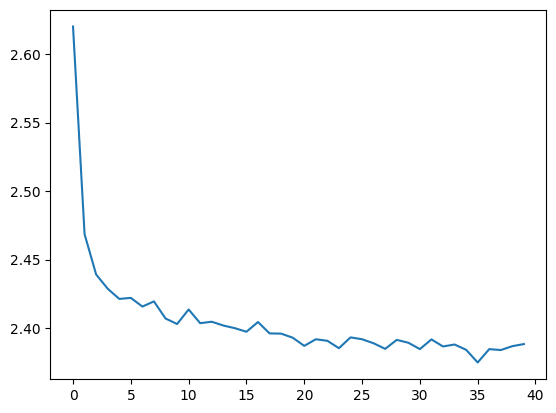

In [7]:
plt.figure()
plt.plot(all_losses)

In [12]:
def sample(rnn, lang, start_char, max_len):
	with torch.no_grad():
		lang_tensor = one_hot_lang_tensor(lang)
		inp = one_hot_input_tensor(start_char)
		hidden = rnn.initHidden()
		word = start_char

		for i in range(max_len):
			out, hidden = rnn(lang_tensor, inp[0], hidden)
			top_confidence, top_i = out.topk(1)
			top_i = top_i[0][0]

			if top_i == n_chars:
				break
			else:
				char = all_chars[top_i]
				word += char

			inp = one_hot_input_tensor(char)

	return word

def samples(lang, start_letters):
	return [sample(rnn, lang, sl, 20) for sl in start_letters]

In [14]:
from string import ascii_lowercase
import pandas as pd

pd.DataFrame({lang : samples(lang, ascii_lowercase) for lang in all_langs})

,czech,dutch,english,finnish,german,italian,japanese,norwegian,polish,portuguese,spanish,swedish
0,alle,anene,anger,anata,aneren,aren,ahoka,ander,arzal,arasta,aren,ander
1,beste,beren,beres,balat,beres,beren,baka,beren,bazac,beres,bender,baran
2,chone,choren,chonde,canta,chenter,canter,choka,cande,coma,conder,carer,cante
3,dover,deres,deres,dakan,deres,deren,doko,derter,dozal,doras,deres,daran
4,erzal,erere,erender,enata,erenter,erester,erosha,ender,erzy,eren,erana,erada
5,forat,fonder,fores,farat,ferter,foren,forak,feren,fozal,fares,fores,forde
6,gende,geren,geren,geista,geren,geren,gakan,geren,grazi,geres,geres,garan
7,hozal,hende,horen,halata,heren,honden,harak,haren,hozali,horas,horas,haran
8,inder,inen,ingeren,iaktata,inger,inger,ioko,inger,inazi,inasta,inger,inger
9,jade,jende,jeres,janta,jenter,jonge,janka,jander,jospa,jande,jande,janger
